In [41]:
import datetime
from pathlib import Path
import pickle
import sys
import warnings
import matplotlib.pyplot as plt
import pandas as pd
import polars as pl
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
from sklearn.metrics import mean_absolute_error

sys.path.append("..")
from src.processing import preprocessing

warnings.filterwarnings("ignore", category=FutureWarning, message="The behavior of DatetimeProperties.to_pydatetime is deprecated")

DATA_DIR = Path("../data")

In [9]:
df = pl.read_csv(DATA_DIR / "PJME_hourly.csv")
split_date = datetime.datetime(2015, 1, 1)

df = preprocessing(df)
df_train, df_test = df.filter(pl.col("ds") <= split_date), df.filter(pl.col("ds") > split_date)
df, df_train, df_test = df.to_pandas(), df_train.to_pandas(), df_test.to_pandas()

### ベースラインモデル
- デフォルト設定のままprophetを使ってみる

In [10]:
model = Prophet()
model.fit(df_train)
pickle.dump(model, open("../data/output/baseline_model.pkl", "wb"))

# 学習データを含めた全区間の予測を出してみる
preds = model.predict(df)
preds.head()

19:51:26 - cmdstanpy - INFO - Chain [1] start processing
19:52:02 - cmdstanpy - INFO - Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2002-01-01 01:00:00,28502.684886,21213.102252,30273.953220,28502.684886,28502.684886,-2796.556102,-2796.556102,-2796.556102,-4430.297380,...,1324.358477,1324.358477,1324.358477,309.382801,309.382801,309.382801,0.0,0.0,0.0,25706.128784
1,2002-01-01 02:00:00,28503.724887,19715.395765,28640.300326,28503.724887,28503.724887,-4278.214948,-4278.214948,-4278.214948,-5927.158022,...,1338.020461,1338.020461,1338.020461,310.922613,310.922613,310.922613,0.0,0.0,0.0,24225.509939
2,2002-01-01 03:00:00,28504.764887,18872.558465,27614.418254,28504.764887,28504.764887,-5131.136057,-5131.136057,-5131.136057,-6790.226342,...,1346.586225,1346.586225,1346.586225,312.504061,312.504061,312.504061,0.0,0.0,0.0,23373.628831
3,2002-01-01 04:00:00,28505.804888,18532.602510,27806.055157,28505.804888,28505.804888,-5257.473277,-5257.473277,-5257.473277,-6922.162373,...,1350.561935,1350.561935,1350.561935,314.127161,314.127161,314.127161,0.0,0.0,0.0,23248.331612
4,2002-01-01 05:00:00,28506.844889,19424.962755,28411.094610,28506.844889,28506.844889,-4571.063491,-4571.063491,-4571.063491,-6237.322742,...,1350.467324,1350.467324,1350.467324,315.791928,315.791928,315.791928,0.0,0.0,0.0,23935.781398


MAE: 5182.584236652587


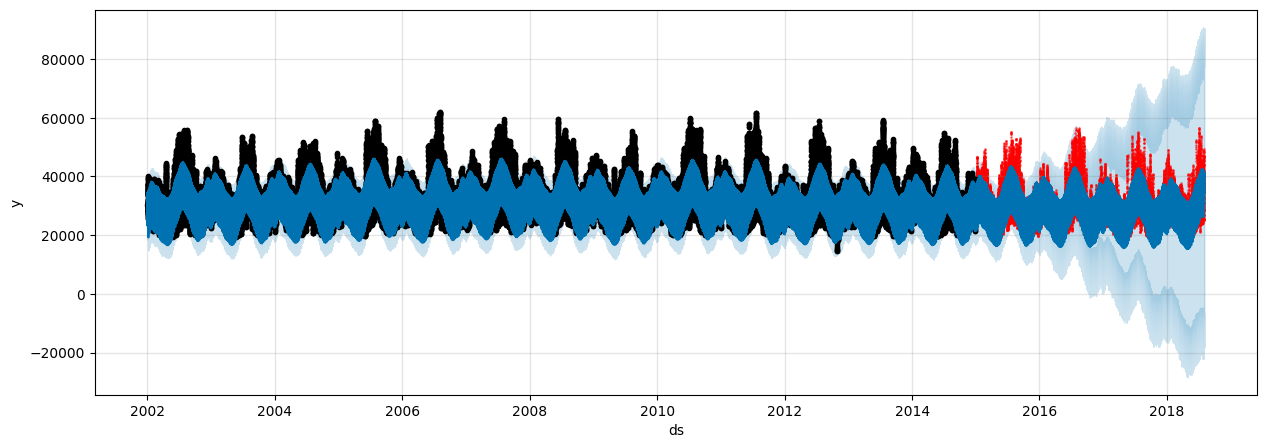

In [42]:
# スコア
mae = mean_absolute_error(
    df_test["y"],
    pl.DataFrame(preds).filter(pl.col('ds') > split_date)["yhat"],
)
print(f"MAE: {mae}")

# 予測結果
_, ax = plt.subplots(figsize=(15, 5))
model.plot(preds, ax)

# 正解データ
# thined = df_test.gather_every(12)
ax.scatter(y=df_test["y"], x=df_test["ds"], s=1, marker="o", alpha=0.5, color="red");

コンポーネントごとに可視化ができる。
- 各時間単位において、周期性があるかの確認と、トレンド傾向の確認ができる
- トレンド予測はデフォルトでは終盤のデータは使われないので、信頼区間が同時に表示される
- このデータは電力需要なので、明らかに曜日、時間帯、季節に周期性がある

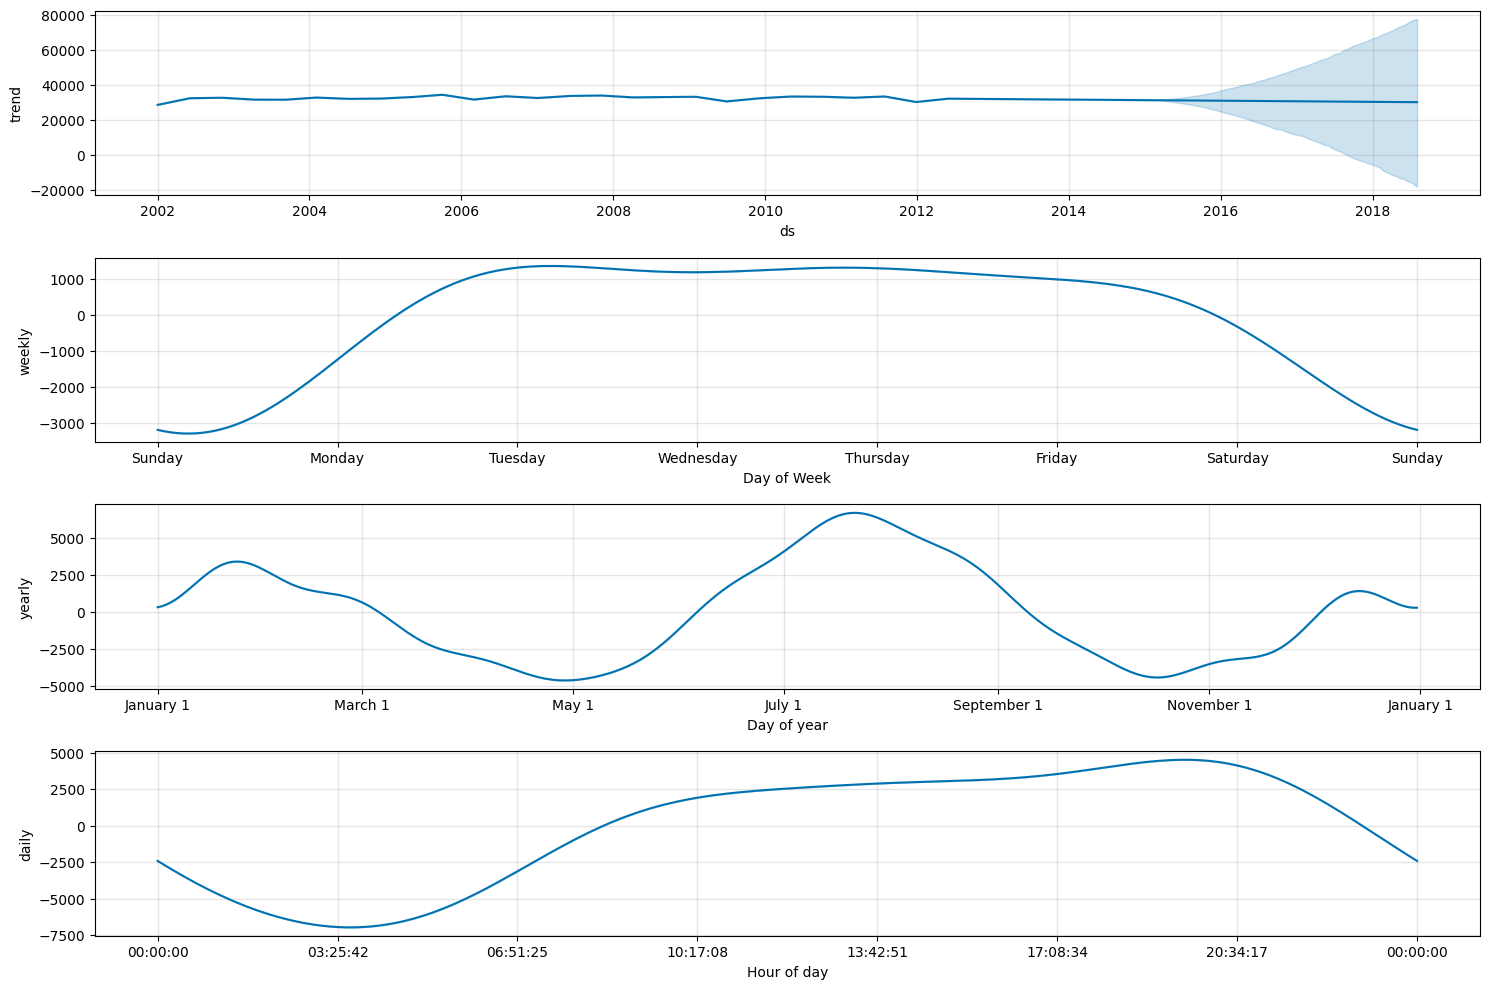

In [12]:
model.plot_components(preds, figsize=(15, 10));

予測の最初の部分を描画してみる。この区間だと、需要が異常に高かった期間を下方に外しており、誤差が大きい。

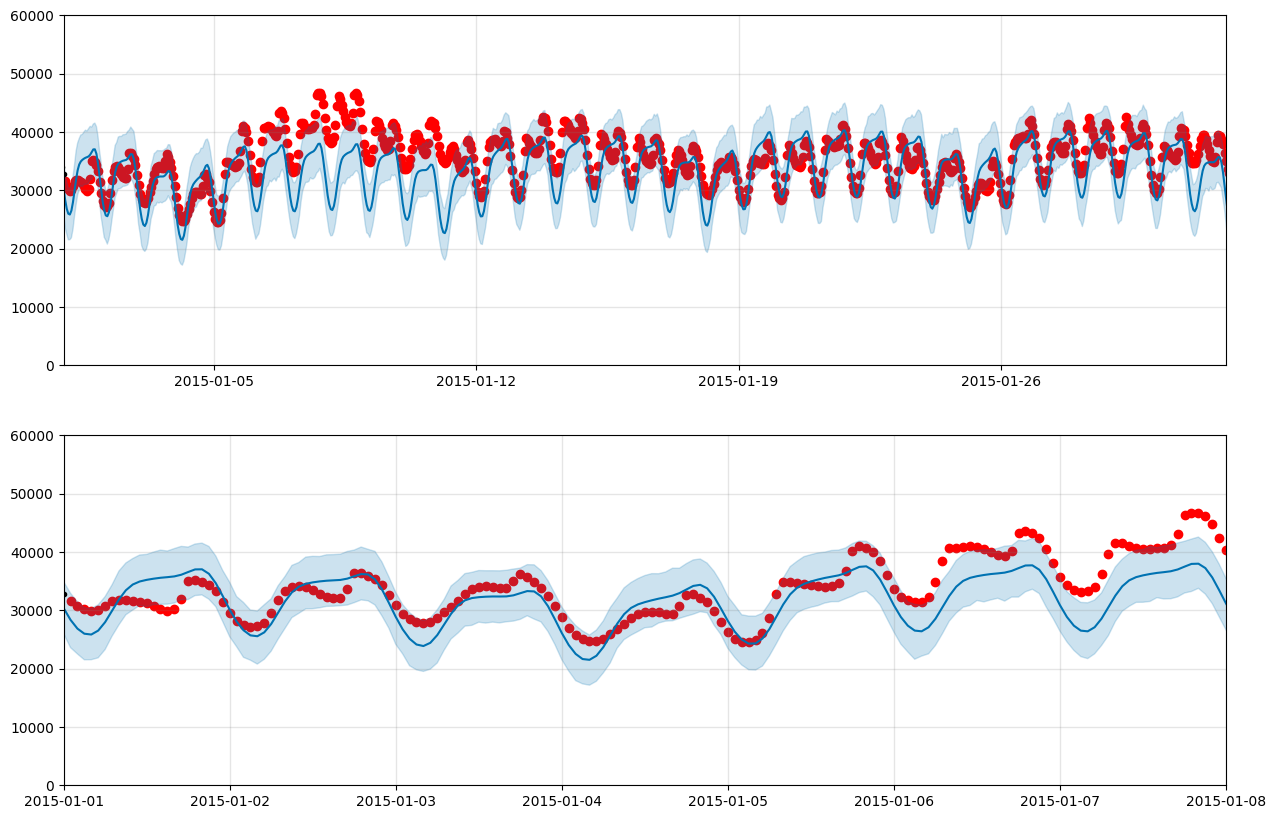

In [37]:
def custom_plot(df: pd.DataFrame, model, start: datetime.datetime, end: datetime.datetime, ax: plt.Axes,):
    ax.scatter(df["ds"], df["y"], color="r")
    fig = model.plot(preds, ax=ax)
    ax.set_xbound(lower=start, upper=end)
    ax.set_ylim(0, 60000);
    ax.set_xlabel("")
    ax.set_ylabel("")

_, axes = plt.subplots(2, 1, figsize=(15, 10))
# 初月
custom_plot(df_test, model, datetime.datetime(2015, 1, 1), datetime.datetime(2015, 2, 1), axes[0])
# 初週
custom_plot(df_test, model, datetime.datetime(2015, 1, 1), datetime.datetime(2015, 1, 8), axes[1])

予測した全区間で、予測とラベルの差異を確認してみる。  
需要が突き抜けて高い区間を過小評価してしまっている。

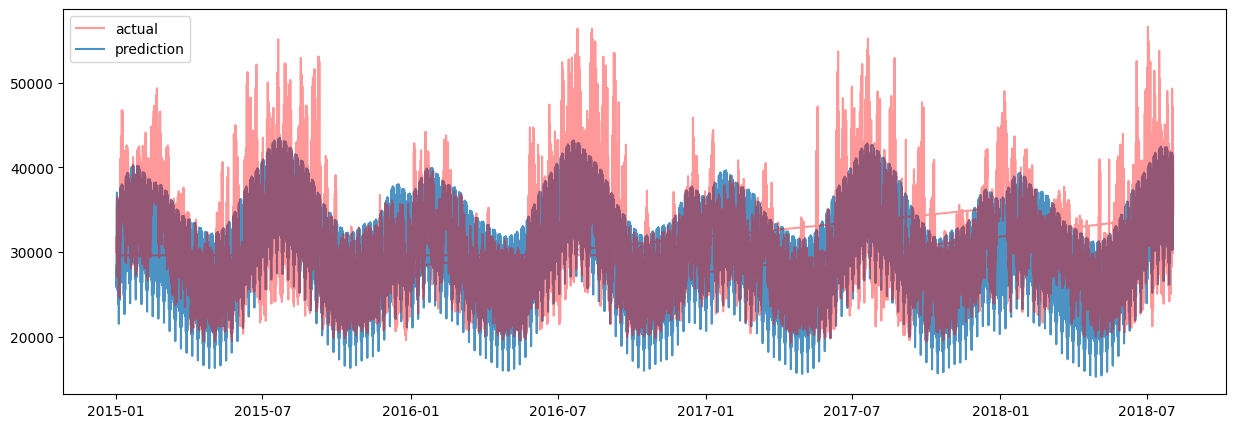

In [73]:
_, ax = plt.subplots(figsize=(15, 5))

ax.plot(df_test["ds"], df_test["y"], alpha=0.4, color="r", zorder=10)
plot_target_preds = preds[preds["ds"] > split_date]
ax.plot(plot_target_preds["ds"], plot_target_preds["yhat"], alpha=0.8);
ax.legend(["actual", "prediction"]);

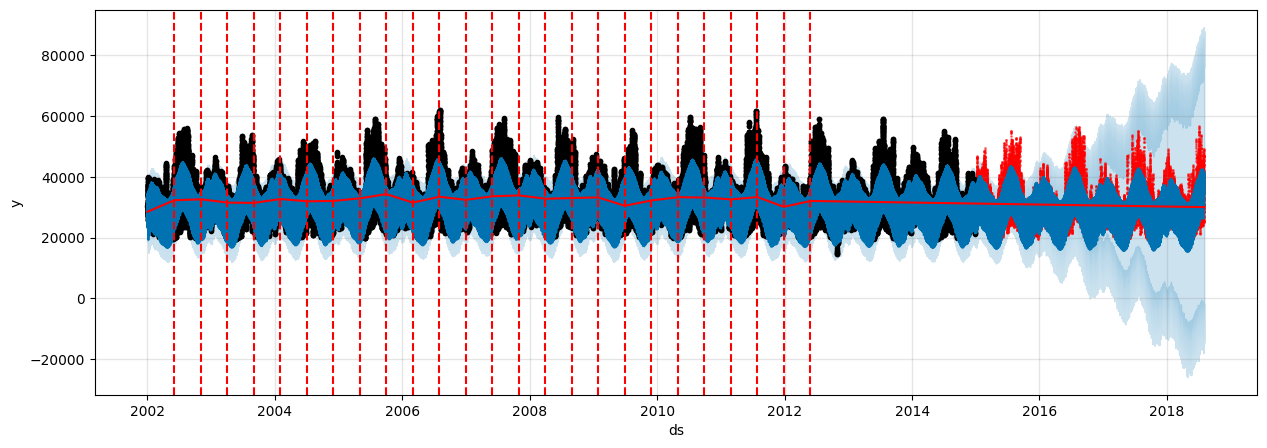

In [10]:
_, ax = plt.subplots(figsize=(15, 5))

fig = model.plot(preds, ax)
ax.scatter(y=df_test["y"], x=df_test["ds"], s=1, marker="o", alpha=0.5, color="red");
add_changepoints_to_plot(fig.gca(), model, preds);